Bridge chart




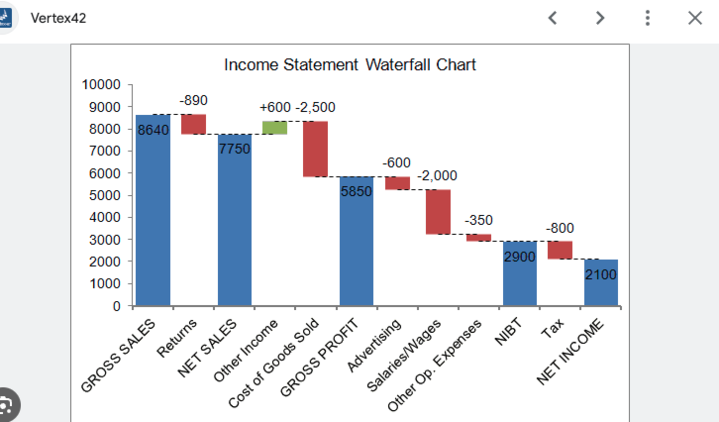


when we take fees that reduces nav/share because it increase the quantity of shares


#### For the previous month

Each of these modifies either Nav or shares, at each point

we need the nav and total shares are each of these points




- Autopool Total ETH value earned (current nav) - (expected nav if nav per share did not change)
- Total Eth taken in fees sum (ETH fees in each fee Event)
- Total ETH value lost in rebalance costs  (this increases NAV)
- Nav lost to 

<!-- 
This is another one - liquidation price of our incentives compared to the then existing price from our pricer -->

we care about the persent change in nav /share 

the bars (for both 1 & 2) are 1. net return annualized 2. gross return (before fees) 3. gross return (before fees & assuming no rebalance txn loss i.e. swap/slippage loss)

In [1]:
from mainnet_launch.constants import ALL_AUTOPOOLS, AUTO_ETH, eth_client
from mainnet_launch.abis.abis import AUTOPOOL_VAULT_ABI
import plotly.io as pio

pio.templates.default = None
contract = eth_client.eth.contract(AUTO_ETH.autopool_eth_addr, abi=AUTOPOOL_VAULT_ABI)

In [3]:
import pandas as pd
import streamlit as st
from datetime import timedelta
from multicall import Call
import plotly.express as px
import numpy as np


from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    get_state_by_one_block,
    identity_with_bool_success,
    safe_normalize_with_bool_success,
    add_timestamp_to_df_with_block_column,
    build_blocks_to_use,
    eth_client,
)

from mainnet_launch.data_fetching.get_events import fetch_events

from mainnet_launch.constants import AUTO_ETH, AUTO_LRT, BAL_ETH, eth_client, AutopoolConstants
from mainnet_launch.abis.abis import AUTOPOOL_VAULT_ABI

import pandas as pd
import streamlit as st
from multicall import Call
from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    add_timestamp_to_df_with_block_column,
    build_blocks_to_use,
    safe_normalize_with_bool_success,
)
import plotly.express as px


def handle_getAssetBreakdown(success, AssetBreakdown):
    if success:
        totalIdle, totalDebt, totalDebtMin, totalDebtMin = AssetBreakdown
        return int(totalIdle + totalDebt) / 1e18
    return None


def getAssetBreakdown_call(name: str, autopool_vault_address: str) -> Call:
    return Call(
        autopool_vault_address,
        ["getAssetBreakdown()((uint256,uint256,uint256,uint256))"],
        [(name, handle_getAssetBreakdown)],
    )


def totalSupply_call(name: str, autopool_vault_address: str) -> Call:
    return Call(
        autopool_vault_address,
        ["totalSupply()(uint256)"],
        [(name, safe_normalize_with_bool_success)],
    )


def build_actual_nav_per_share_df(autopool: AutopoolConstants) -> pd.DataFrame:

    calls = [
        getAssetBreakdown_call("actual_nav", autopool.autopool_eth_addr),
        totalSupply_call("actual_shares", autopool.autopool_eth_addr),
    ]
    blocks = build_blocks_to_use()
    df = get_raw_state_by_blocks(calls, blocks)
    df["actual_nav_per_share"] = df["actual_nav"] / df["actual_shares"]
    daily_nav_shares_df = df.resample('1D').last()
    return daily_nav_shares_df



def build_fee_shares_minted_df(autopool: AutopoolConstants):
    autoETH_vault = eth_client.eth.contract(autopool.autopool_eth_addr, abi=AUTOPOOL_VAULT_ABI)
    FeeCollected_df = add_timestamp_to_df_with_block_column(fetch_events(autoETH_vault.events.FeeCollected))
    PeriodicFeeCollected_df = add_timestamp_to_df_with_block_column(
        fetch_events(autoETH_vault.events.PeriodicFeeCollected)
    )
    PeriodicFeeCollected_df["new_shares_from_periodic_fees"] = PeriodicFeeCollected_df["mintedShares"] / 1e18
    FeeCollected_df["new_shares_from_streaming_fees"] = FeeCollected_df["mintedShares"] / 1e18
    fee_df = pd.concat(
        [
            PeriodicFeeCollected_df[["new_shares_from_periodic_fees"]],
            FeeCollected_df[["new_shares_from_streaming_fees"]],
        ]
    )
    daily_fee_share_df = fee_df.resample("1D").sum()
    return daily_fee_share_df


daily_fee_share_df = build_fee_shares_minted_df(AUTO_ETH)
daily_nav_shares_df = build_actual_nav_per_share_df(AUTO_ETH)
daily_fee_share_df

2024-10-23 12:49:15.139 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 12:49:15.165 
  command:

    streamlit run /home/parker/Documents/Tokemak/v2-rebalance-dashboard/.venv/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-10-23 12:49:15.166 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 12:49:15.166 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 12:49:15.167 No runtime found, using MemoryCacheStorageManager
2024-10-23 12:49:15.235 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-23 12:49:15.236 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


,new_shares_from_periodic_fees,new_shares_from_streaming_fees
timestamp,,
2024-09-19 00:00:00+00:00,0.625610,0.000000
2024-09-20 00:00:00+00:00,0.091670,0.000000
2024-09-21 00:00:00+00:00,0.131287,0.418534
2024-09-22 00:00:00+00:00,0.100057,0.257884
2024-09-23 00:00:00+00:00,0.114859,0.285512
2024-09-24 00:00:00+00:00,0.129339,0.332878
2024-09-25 00:00:00+00:00,0.129859,0.000000
2024-09-26 00:00:00+00:00,0.137648,0.118292
2024-09-27 00:00:00+00:00,0.142733,1.308450


In [4]:
daily_nav_shares_df

,actual_nav,actual_shares,actual_nav_per_share
timestamp,,,
2024-09-15 00:00:00+00:00,0.176129,0.176129,1.000000
2024-09-16 00:00:00+00:00,902.012316,902.012316,1.000000
2024-09-17 00:00:00+00:00,1653.384535,1653.392359,0.999995
2024-09-18 00:00:00+00:00,2993.877068,2994.157550,0.999906
2024-09-19 00:00:00+00:00,3901.645343,3903.814760,0.999444
2024-09-20 00:00:00+00:00,4163.864369,4166.393328,0.999393
2024-09-21 00:00:00+00:00,4313.707350,4315.775101,0.999521
2024-09-22 00:00:00+00:00,4360.300549,4362.731653,0.999443
2024-09-23 00:00:00+00:00,5025.041538,5027.483441,0.999514
